In [122]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
class Nodo:
      GuiaT_N :Dict[int, 'Nodo'] = {}
      GuiaTT_D :Dict[tuple, int] = {}
      GuiaP_N :Dict[tuple, 'Nodo'] = {} 
      def __init__(self, posicion: tuple):
            self.tag = len(Nodo.GuiaT_N)
            Nodo.GuiaT_N[self.tag] = self
            Nodo.GuiaP_N[posicion] = self
            self.vecinos = []
            self.posicion = posicion
      def AgregarVecino(self, vecino: 'Nodo', distancia: int = None):
            vecino = Nodo.GuiaP_N.get(vecino, None)
            if vecino != None:
                  self.vecinos.append(vecino)
                  vecino.vecinos.append(self)
                  Nodo.GuiaTT_D[(self.tag, vecino.tag)] = distancia if distancia != None else np.random.randint(5)
                  Nodo.GuiaTT_D[(vecino.tag, self.tag)] = distancia if distancia != None else np.random.randint(5)
class Pasajero:
      tag_count = 0
      def __init__(self, tag_inicio = None, tag_final = None) -> None:
            self.tag = Pasajero.tag_count
            Pasajero.tag_count += 1
            lstPT = list(Nodo.GuiaT_N.keys()).copy()
            if tag_inicio == None:
                  k = np.random.randint(len(lstPT))
                  self.Tag_inicio = lstPT[k]
                  lstPT.remove(k)
            else:
                  self.Tag_inicio = tag_inicio
                  
            if tag_final == None:
                  k = np.random.randint(len(lstPT))
                  self.Tag_final = lstPT[k]
            else:
                  self.Tag_final = tag_final
            
      def ReiniciarTags():
            Pasajero.tag_count = 0
            
      def toStr(self):
            return f"{self.tag} : {self.Tag_inicio} -> {self.Tag_final}"
      
class Ruta:
      def __init__(self, distancia = 0, n_tags = [], fijo = False) -> None:
            self.distancia = distancia
            self.n_tags = n_tags
            self.fijo = fijo

class Ciudad:

      def __init__(self, lado: int, n_pasajeros: int) -> None:
            self.Lado = lado
            #Se define una ciudad cuadriculada
            self.Nodos = np.array([[Nodo((i,j)) for i in range(lado)] for j in range(lado)], dtype=Nodo)
            for i in range(lado):
                  for j in range(lado):
                        nposicion = (i,j)
                        nodo_ini = Nodo.GuiaP_N[nposicion]
                        nodo_ini.AgregarVecino((i + 1, j))
                        nodo_ini.AgregarVecino((i, j + 1))
            #DefinirPasajeros
            self.pasajeros = [Pasajero() for i in range(n_pasajeros)]
            self.Mdistancias = self.GenerarMatrizDistancias()
            
      def MostrarPasajeros(self):
            print(f"Hay {len(self.pasajeros)} pasajeros")
            for p in self.pasajeros:
                  print(p.toStr())
                  
      def GenerarMatrizDistancias(self):
            Distancias = {}        
            
            for i in range(self.Lado):
                  for j in range(self.Lado):
                        n_origen :Nodo = Nodo.GuiaP_N[(i,j)]
                        #n_pendinetes = list(Nodo.GuiaT_N.keys())
                        dic_rutas = {n_origen.tag : Ruta(distancia= 0, n_tags= [n_origen.tag], fijo= True)}
                        rfs = [r for r in dic_rutas.values() if r.fijo]
                        #print(f"Para el nodo {n_origen.tag} - {(i,j)}")
                        while(len(rfs) != len(Nodo.GuiaT_N)):
                              #Para todo vecino de cada nodo fijo agregarlo al diccionario de rutas o una version menos pesada
                              #print("Fijos :",[r.n_tags for r in rfs])
                              for rf in rfs:
                                    nf = Nodo.GuiaT_N[rf.n_tags[-1]]
                                    for nv in nf.vecinos:
                                          d = Nodo.GuiaTT_D[(nf.tag, nv.tag)]
                                          if (nv.tag not in dic_rutas.keys() or d < dic_rutas[nv.tag].distancia):
                                                nr_n_tags = rf.n_tags.copy()
                                                nr_n_tags.append(nv.tag)
                                                dic_rutas[nv.tag] = Ruta(distancia = d,n_tags = nr_n_tags)
                              
                              rnfs = [r for r in dic_rutas.values() if not r.fijo]
                              #print("No fijo :",[r.n_tags for r in rnfs])
                              rnfs.sort(key=lambda r: r.distancia)
                              rnfs[0].fijo = True
                                    
                              rfs = [r for r in dic_rutas.values() if r.fijo]
                        Distancias[n_origen.tag] = dic_rutas
                              
            return Distancias
      
      
      
LADO = 5
NPASAJEROS = 10
C = Ciudad(LADO, NPASAJEROS)


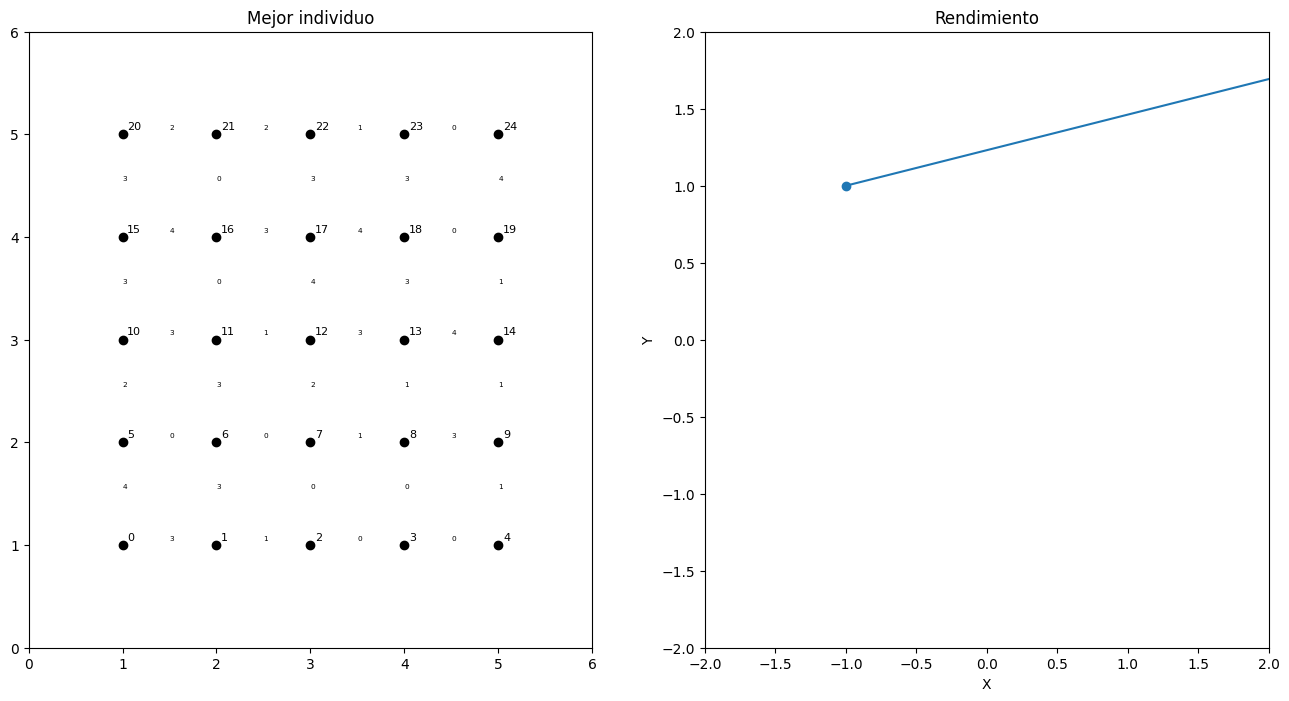

In [123]:

# create a figure and axes
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

Pading = 1
GDis = 1
FS = 8
Elevacion = 0.05
# set up the subplots as needed
ax1.set_title('Mejor individuo')
ax1.set_xlim((0, LADO + Pading))            
ax1.set_ylim((0, LADO + Pading))
#ax1.axis('off')
ax1.set_xlabel('')
ax1.set_ylabel('')

for nodo in Nodo.GuiaT_N.values():
      X = nodo.posicion[0] + Pading
      Y = nodo.posicion[1] + Pading
      ax1.plot(X, Y, 'o', c = "black")
      ax1.text(X + Elevacion, Y + Elevacion, nodo.tag, fontsize = FS)
      for nodo_vecino in nodo.vecinos:
            if nodo_vecino.tag > nodo.tag: continue
            Xv = nodo_vecino.posicion[0] + Pading
            Yv = nodo_vecino.posicion[1] + Pading
            d = Nodo.GuiaTT_D[(nodo.tag, nodo_vecino.tag)]
            ax1.text(X/2 + Xv/2, Y/2 + Yv/2 + Elevacion, d, fontsize= 2 * FS/ 3)

"""
NP = C.getNodosPasajeros()
ND = C.getNodosDestinos()
for i in range(LADO):
      for j in range(LADO):
            str = f"{NP[i,j]}🙍|{ND[i,j]}⤵"
            ax1.text(X[i,j] - len(str) / (2*FS), Y[i,j] + 2*Elevacion, str, fontsize=FS, fontname='Segoe UI Emoji',)
"""

ax2.set_xlim((-2,2))
ax2.set_ylim((-2,2))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Rendimiento')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
line1, = ax1.plot([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects
line2, = ax1.plot([], [], 'r', lw=2)
pt1, = ax2.plot([], [], 'g.', ms=20)
line3, = ax2.plot([], [], 'y', lw=2)




x1, y1 = [-1, 12], [1, 4]
ax2.plot(x1, y1, marker = 'o')

In [124]:
# animation function. This is called sequentially
def drawframe(n):
    x = np.linspace(0, 2, 1000)
    y1 = np.sin(2 * np.pi * (x - 0.01 * n))
    y2 = np.cos(2 * np.pi * (x - 0.01 * n))
    line1.set_data(x, y1)
    line2.set_data(x, y2)
    line3.set_data(y1[0:50],y2[0:50])
    pt1.set_data(y1[0],y2[0])
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1,line2)

In [125]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=20, interval=20, blit=True)

C:\Users\Arnoldjbs\AppData\Local\Temp\ipykernel_27876\2572033083.py:9: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pt1.set_data(y1[0],y2[0])


NameError: name 'txt_title' is not defined

In [164]:
from IPython.display import HTML
HTML(anim.to_html5_video())

C:\Users\Arnoldjbs\AppData\Local\Temp\ipykernel_32396\2572033083.py:9: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  pt1.set_data(y1[0],y2[0])
